# Citation

Dataset URL:
https://nihcc.app.box.com/v/ChestXray-NIHCC

Acknowledgements:
NIH Clinical Center for the dataset

Citation:
Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

# Setup Test Mode

In [1]:
# Set mode (Test or Not)
test = False

# Structure Data

In [2]:
import pandas as pd

findings_df = pd.read_csv("./data/Data_Entry_2017_v2020.csv")

findings_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [3]:
findings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 9.4+ MB


In [4]:
# retain only needed columns
cols_to_retain = ['Image Index',
                  'Finding Labels',]
findings_df = findings_df[cols_to_retain]
findings_df.head()

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000003_001.png,Hernia


In [5]:
# Sample to speed up training (Test Only)
if test:
    sampled_df = findings_df.sample(frac=0.2, random_state=42) # 20% sample
    findings_df = sampled_df
    findings_df.to_csv('./data/sampled_labels.csv', index=False)
else:
    findings_df.to_csv('./data/labels.csv', index=False)

In [6]:
# Create binary columns for the findings for stratification
from sklearn.preprocessing import MultiLabelBinarizer

# create temporary dataframe
df = findings_df.copy()

# Create column with list of labels
df['labels'] = df['Finding Labels'].str.split('|')

# One-hot encode the labels
mlb = MultiLabelBinarizer()
one_hot_labels = pd.DataFrame(mlb.fit_transform(df['labels']), columns=mlb.classes_)

one_hot_labels.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [7]:
mlb.classes_

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype=object)

In [8]:
# Reset index to avoid mismatch and concatenate the one-hot encoded labels
df = pd.concat([df.reset_index(drop=True), one_hot_labels], axis=1)
df.head()

,Image Index,Finding Labels,labels,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,[Cardiomegaly],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,"[Cardiomegaly, Emphysema]",0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,"[Cardiomegaly, Effusion]",0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,[No Finding],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,00000003_001.png,Hernia,[Hernia],0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [9]:
# Use one-hot-coded columns as statratification columns
strata_cols = ['Atelectasis', 
               'Cardiomegaly', 
               'Consolidation', 
               'Edema',
               'Effusion', 
               'Emphysema', 
               'Fibrosis', 
               'Hernia', 
               'Infiltration',
               'Mass', 
               'No Finding', 
               'Nodule', 
               'Pleural_Thickening', 
               'Pneumonia',
               'Pneumothorax']
df['stratify_col'] = df[strata_cols].astype(str).agg(''.join, axis=1)
df

,Image Index,Finding Labels,labels,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,stratify_col
0,00000001_000.png,Cardiomegaly,[Cardiomegaly],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,010000000000000
1,00000001_001.png,Cardiomegaly|Emphysema,"[Cardiomegaly, Emphysema]",0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,010001000000000
2,00000001_002.png,Cardiomegaly|Effusion,"[Cardiomegaly, Effusion]",0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,010010000000000
3,00000002_000.png,No Finding,[No Finding],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,000000000010000
4,00000003_001.png,Hernia,[Hernia],0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,000000010000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,"[Mass, Pneumonia]",0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,000000000100010
112116,00030802_000.png,No Finding,[No Finding],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,000000000010000
112117,00030803_000.png,No Finding,[No Finding],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,000000000010000
112118,00030804_000.png,No Finding,[No Finding],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,000000000010000


In [10]:
# Remove strata with less than 30 observations
strata_counts = df['stratify_col'].value_counts()
strata_to_keep = strata_counts[strata_counts >= 30].index
df_filtered = df[df['stratify_col'].isin(strata_to_keep)]
df_filtered

,Image Index,Finding Labels,labels,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,stratify_col
0,00000001_000.png,Cardiomegaly,[Cardiomegaly],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,010000000000000
2,00000001_002.png,Cardiomegaly|Effusion,"[Cardiomegaly, Effusion]",0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,010010000000000
3,00000002_000.png,No Finding,[No Finding],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,000000000010000
4,00000003_001.png,Hernia,[Hernia],0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,000000010000000
5,00000003_002.png,Hernia,[Hernia],0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,000000010000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112114,00030801_000.png,No Finding,[No Finding],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,000000000010000
112116,00030802_000.png,No Finding,[No Finding],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,000000000010000
112117,00030803_000.png,No Finding,[No Finding],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,000000000010000
112118,00030804_000.png,No Finding,[No Finding],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,000000000010000


In [11]:
df_filtered.shape[0]

108938

In [12]:
# Remove inconsistent rows
finding_cols = strata_cols
def is_consistent(row):
    if row['No Finding'] == 1:
        # If 'No Finding' is 1, all other columns should be 0
        return sum(row[finding_cols]) == 1
    return True  # If 'No Finding' is 0, any combination is allowed

In [13]:
# Remove rows where 'No Finding' is 1 but there are findings
df_filtered = df_filtered[df_filtered.apply(is_consistent, axis=1)]

In [14]:
df_filtered.shape[0]

108938

In [15]:
# Create new labels column focusing on Pneumonia and Pneumothorax
def create_findings_column(row):
    findings = []
    if row['No Finding'] == 1:
        findings.append('No Finding')
    if row['Pneumonia'] == 1:
        findings.append('Pneumonia')
    if row['Pneumothorax'] == 1:
        findings.append('Pneumothorax')
    if not findings:  # If none of the above conditions are met
        findings.append('Other')
    return '|'.join(findings)

# Apply the function to create the new 'findings' column
df_filtered['findings'] = df_filtered.apply(create_findings_column, axis=1)
df_filtered

,Image Index,Finding Labels,labels,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,stratify_col,findings
0,00000001_000.png,Cardiomegaly,[Cardiomegaly],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,010000000000000,Other
2,00000001_002.png,Cardiomegaly|Effusion,"[Cardiomegaly, Effusion]",0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,010010000000000,Other
3,00000002_000.png,No Finding,[No Finding],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,000000000010000,No Finding
4,00000003_001.png,Hernia,[Hernia],0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,000000010000000,Other
5,00000003_002.png,Hernia,[Hernia],0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,000000010000000,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112114,00030801_000.png,No Finding,[No Finding],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,000000000010000,No Finding
112116,00030802_000.png,No Finding,[No Finding],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,000000000010000,No Finding
112117,00030803_000.png,No Finding,[No Finding],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,000000000010000,No Finding
112118,00030804_000.png,No Finding,[No Finding],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,000000000010000,No Finding


# Train Test Split

In [16]:
# Split the file into train and test but test
from sklearn.model_selection import train_test_split

# training 85%, validation 10%, test 5%
train_df, temp_df = train_test_split(df_filtered, test_size=0.15, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.33, random_state=42)

In [17]:
# Print counts of each of the findings columns in the train set
for col in strata_cols:
    print(f"{col}: {train_df[col].sum()}")

Atelectasis: 8373
Cardiomegaly: 1797
Consolidation: 2984
Edema: 1403
Effusion: 9531
Emphysema: 1540
Fibrosis: 996
Hernia: 88
Infiltration: 14841
Mass: 3826
No Finding: 48288
Nodule: 4285
Pleural_Thickening: 2073
Pneumonia: 812
Pneumothorax: 3624


In [18]:
# Create an is_valid column
train_df['is_valid'] = 0
val_df['is_valid'] = 1

# Store the resulting training and test dataframe into a csv
findings_df = pd.concat([train_df, val_df], ignore_index=True)
findings_df

,Image Index,Finding Labels,labels,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,...,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,stratify_col,findings,is_valid
0,00005564_004.png,No Finding,[No Finding],0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,000000000010000,No Finding,0
1,00014945_007.png,No Finding,[No Finding],0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,000000000010000,No Finding,0
2,00002720_007.png,Effusion,[Effusion],0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,000010000000000,Other,0
3,00000613_002.png,No Finding,[No Finding],0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,000000000010000,No Finding,0
4,00010356_000.png,Infiltration,[Infiltration],0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,000000001000000,Other,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103486,00028866_003.png,Atelectasis,[Atelectasis],1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,100000000000000,Other,1
103487,00014946_002.png,No Finding,[No Finding],0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,000000000010000,No Finding,1
103488,00027821_001.png,No Finding,[No Finding],0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,000000000010000,No Finding,1
103489,00010552_002.png,No Finding,[No Finding],0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,000000000010000,No Finding,1


In [19]:
if test:
    findings_df.to_csv('./data/sampled_labels.csv', index=False)
    test_df.to_csv('./data/sampled_testset.csv', index=False)
else:
    findings_df.to_csv('./data/labels.csv', index=False)
    test_df.to_csv('./data/testset.csv', index=False)

# Train Model

In [20]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import numpy as np
#import timm
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score
import random
import os
#import platform

In [21]:
# set path to images
if test:
    path_text = '/mnt/f/datasets/nihcxr/images_sampled'
    findings_df = pd.read_csv('./data/sampled_labels.csv')
else:
    path_text = '/mnt/f/datasets/nihcxr/images_train'
    findings_df = pd.read_csv('./data/labels.csv')

# create training and validation sets
train_df = findings_df[findings_df['is_valid']==0]
val_df = findings_df[findings_df['is_valid']==1]

path = Path(path_text)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [22]:
# Create label_to_idx dictionary
def create_label_index(dataframe, label_column='findings', delimiter='|'):
    # Get all unique labels
    all_labels = set()
    for labels in dataframe[label_column]:
        all_labels.update(labels.split(delimiter))
    
    # Create the label_to_idx dictionary
    label_to_idx = {label: idx for idx, label in enumerate(sorted(all_labels))}
    
    return label_to_idx

In [23]:
# Create the label_to_idx dictionary
label_to_idx = create_label_index(findings_df)

In [24]:
# Print the dictionary to verify
print("Label to Index mapping:")
for label, idx in label_to_idx.items():
    print(f"{label}: {idx}")

Label to Index mapping:
No Finding: 0
Other: 1
Pneumonia: 2
Pneumothorax: 3


In [25]:
# dataframe info
img_filename = 'Image Index'
labels_column = 'findings'
delimiter = '|'

# ChestXrayDataset that uses label_to_idx
class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, img_dir, label_to_idx, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.label_to_idx = label_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx][img_filename]
        image = Image.open(f"{self.img_dir}/{img_name}").convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        labels = self.dataframe.iloc[idx][labels_column].split(delimiter)
        label_tensor = torch.zeros(len(self.label_to_idx))
        for label in labels:
            label_tensor[self.label_to_idx[label]] = 1
        
        return image, label_tensor

In [26]:
# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 1 - x), # Invert the image to work better with pretrained ImageNet models
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [27]:
# Function to show random samples from the dataset
def show_batch(dataset, num_items=6, figsize=(20, 10)):
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()

    # Get random indices
    indices = random.sample(range(len(dataset)), num_items)

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0)  # Change from CxHxW to HxWxC
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Denormalize
        img = img.numpy()
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].axis('off')

        # Get labels
        label_names = [k for k, v in dataset.label_to_idx.items() if label[v] == 1]
        axes[i].set_title('\n'.join(label_names), fontsize=10)

    plt.tight_layout()
    plt.show()

In [28]:
# Create datasets
train_dataset = ChestXrayDataset(train_df, path_text, label_to_idx, transform=transform)
val_dataset = ChestXrayDataset(val_df, path_text, label_to_idx, transform=transform)

# Create dataloaders
batch_size=64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

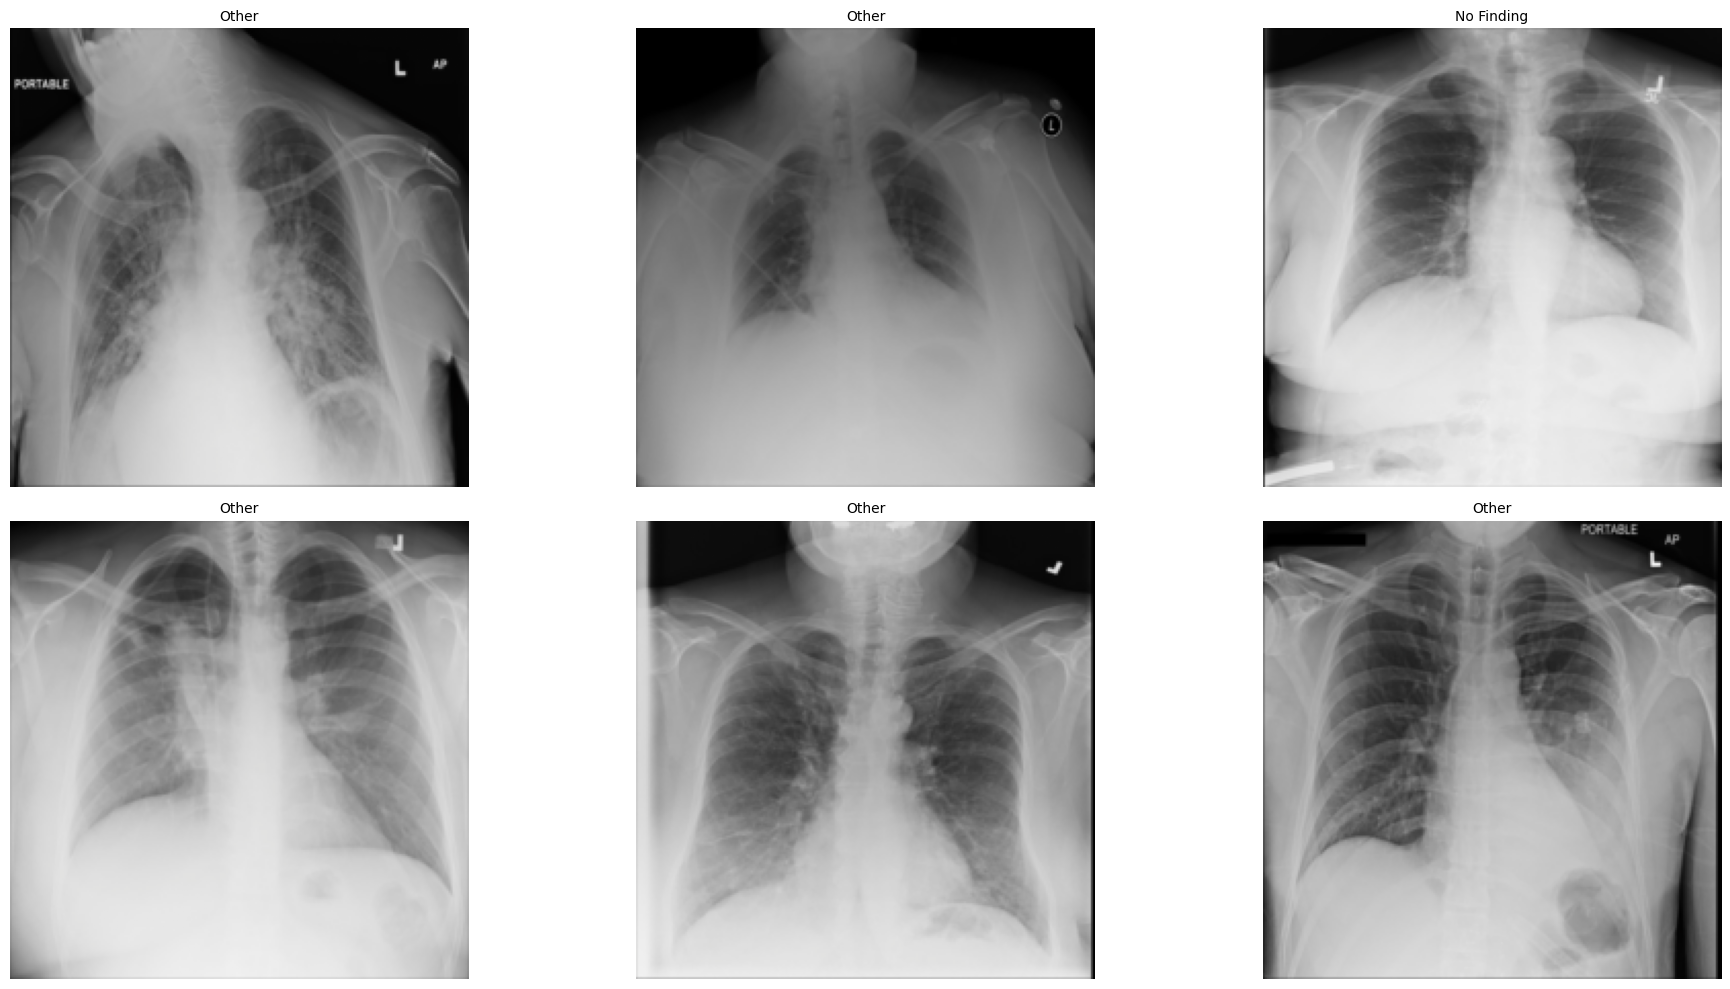

In [29]:
# Show a batch of training data
show_batch(train_dataset)

In [30]:
def calculate_class_weights(dataframe, label_column=labels_column, delimiter=delimiter):
    # Extract all labels
    all_labels = [labels.split(delimiter) for labels in dataframe[label_column]]
    
    # Use MultiLabelBinarizer to get binary representation
    mlb = MultiLabelBinarizer()
    binary_labels = mlb.fit_transform(all_labels)
    
    # Get unique labels
    unique_labels = mlb.classes_
    
    # Calculate weights for each class
    class_weights = {}
    for i, class_label in enumerate(unique_labels):
        class_weights[class_label] = compute_class_weight(
            class_weight='balanced',
            classes=np.array([0, 1]),
            y=binary_labels[:, i]
        )[1]  # We only need the weight for the positive class
    
    return class_weights

In [31]:
# Calculate class weights
combined_df = pd.concat([train_df, val_df])
class_weights_dict = calculate_class_weights(combined_df)

# Convert class weights to a tensor
class_weights = torch.tensor(
    [class_weights_dict[label] for label in label_to_idx.keys()])
class_weights = class_weights.to(device)

In [32]:
# Print class weights
print("Class Weights:")
for label, weight in zip(label_to_idx.keys(), class_weights):
    print(f"{label}: {weight.item():.4f}")

Class Weights:
No Finding: 0.9024
Other: 1.2658
Pneumonia: 53.6223
Pneumothorax: 12.0227


In [33]:
# Function to compute losses for the entire dataset
def compute_losses(model, dataloader, criterion, device):
    model.eval()
    all_losses = []
    all_preds = []
    all_targets = []
    all_img_files = []

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Computing losses"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            # Compute loss for each sample in the batch
            for i in range(inputs.size(0)):
                loss = criterion(outputs[i].unsqueeze(0), targets[i].unsqueeze(0))
                all_losses.append(loss.item())
            
            all_preds.append(torch.sigmoid(outputs).cpu())
            all_targets.append(targets.cpu())
            all_img_files.extend([dataloader.dataset.dataframe.iloc[i][img_filename] for i in range(len(targets))])

    return np.array(all_losses), torch.cat(all_preds), torch.cat(all_targets), all_img_files

In [34]:
# Function to plot top losses
def plot_top_losses(losses, preds, targets, path, img_files, label_to_idx, top_k=9, figsize=(20, 15)):
    idx_to_label = {v: k for k, v in label_to_idx.items()}
    sorted_idx = np.argsort(losses)[::-1]
    top_k_idx = sorted_idx[:top_k]

    fig, axes = plt.subplots(3, 3, figsize=figsize)
    axes = axes.flatten()

    for i, idx in enumerate(top_k_idx):
        img_path = os.path.join(path, img_files[idx])
        img = Image.open(img_path).convert('RGB')
        axes[i].imshow(img)
        axes[i].axis('off')

        true_labels = [idx_to_label[j] for j in range(len(targets[idx])) if targets[idx][j] == 1]
        pred_labels = [idx_to_label[j] for j in range(len(preds[idx])) if preds[idx][j] > 0.5]

        title = f"Loss: {losses[idx]:.4f}\nTrue: {', '.join(true_labels)}\nPred: {', '.join(pred_labels)}"
        axes[i].set_title(title, fontsize=10)

    plt.tight_layout()
    plt.show()


In [35]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"Early stopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

In [36]:
def calculate_metrics(outputs, targets, threshold=0.5):
    # Convert outputs to binary predictions
    predictions = (outputs >= threshold).float()
    
    # Move tensors to CPU and convert to numpy arrays
    predictions = predictions.cpu().numpy()
    targets = targets.cpu().numpy()
    
    # Calculate accuracy
    accuracy = accuracy_score(targets, predictions)
    
    # Calculate F1 score, handling the case where a class might not be present
    f1 = f1_score(targets, predictions, average='weighted', zero_division=0)
    
    return accuracy, f1

In [37]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for name, param in model.named_parameters():
            if "fc" not in name:  # Freeze all layers except the final fully connected layer
                param.requires_grad = False
            else:
                param.requires_grad = True
    else:
        for param in model.parameters():
            param.requires_grad = True

In [38]:
def create_optimizer(model, lr=0.001, feature_extract=True):
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            params_to_update.append(param)
    
    if not params_to_update:
        raise ValueError("No parameters to optimize. Check if all parameters are frozen.")
    
    return optim.Adam(params_to_update, lr=lr)

In [39]:
def train_model(model, train_loader, val_loader, criterion, device, num_epochs=10, patience=5, freeze_epochs=3):
    early_stopping = EarlyStopping(patience=patience)
    best_val_loss = float('inf')
    best_model_state = None

    # Start with feature extracting
    set_parameter_requires_grad(model, feature_extracting=True)
    # Only update the newly added layers
    optimizer = create_optimizer(model, lr=0.001, feature_extract=True)

    for epoch in range(num_epochs):
        if epoch == freeze_epochs:
            print("Unfreezing all layers")
            set_parameter_requires_grad(model, feature_extracting=False)
            # Update all parameters
            optimizer = create_optimizer(model, lr=0.0001, feature_extract=False)

        model.train()
        train_loss = 0.0
        train_accuracy = 0.0
        train_f1 = 0.0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            acc, f1 = calculate_metrics(torch.sigmoid(outputs), labels)
            train_accuracy += acc
            train_f1 += f1
            
            train_pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{acc:.4f}', 'f1': f'{f1:.4f}'})
        
        avg_train_loss = train_loss / len(train_loader)
        avg_train_accuracy = train_accuracy / len(train_loader)
        avg_train_f1 = train_f1 / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        val_f1 = 0.0
        
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
        with torch.no_grad():
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                acc, f1 = calculate_metrics(torch.sigmoid(outputs), labels)
                val_accuracy += acc
                val_f1 += f1
                
                val_pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{acc:.4f}', 'f1': f'{f1:.4f}'})
        
        avg_val_loss = val_loss / len(val_loader)
        avg_val_accuracy = val_accuracy / len(val_loader)
        avg_val_f1 = val_f1 / len(val_loader)
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, Train F1: {avg_train_f1:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}, Val F1: {avg_val_f1:.4f}')
        
        # Check if this is the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            print(f"New best model saved with validation loss: {best_val_loss:.4f}")
        
        # Early stopping
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    
    # Load the best model
    model.load_state_dict(best_model_state)

    return model, best_val_loss

In [40]:
# Load a pre-trained ResNet50 and modify for multi-label classification
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(label_to_idx))  # Adjust the output size for multi-label
model = model.to(device)

In [12]:
# Loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
#optimizer = optim.Adam(model.parameters(), lr=0.001)

# Ensure your DataLoader is optimized
num_workers = 4
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=num_workers, 
                          pin_memory=True)
val_loader = DataLoader(val_dataset, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        num_workers=num_workers, 
                        pin_memory=True)

NameError: name 'nn' is not defined

In [42]:
model, best_val_loss = train_model(model, 
                                   train_loader, 
                                   val_loader, 
                                   criterion,  
                                   device, 
                                   num_epochs=100, 
                                   patience=5,
                                   freeze_epochs=3)

print(f"Training completed. Best validation loss: {best_val_loss:.4f}")

Epoch 1/100 [Val]: 100%|██████████| 256/256 [09:37<00:00,  2.26s/it, loss=0.7823, acc=0.6667, f1=0.7746]


Epoch 1/100
Train Loss: 0.7656, Train Acc: 0.4918, Train F1: 0.5974
Val Loss: 0.7634, Val Acc: 0.5082, Val F1: 0.6005
New best model saved with validation loss: 0.7634


Epoch 2/100 [Val]: 100%|██████████| 256/256 [14:08<00:00,  3.31s/it, loss=0.7779, acc=0.6190, f1=0.7344]


Epoch 2/100
Train Loss: 0.7301, Train Acc: 0.4928, Train F1: 0.6169
Val Loss: 0.7491, Val Acc: 0.4494, Val F1: 0.6151
New best model saved with validation loss: 0.7491


Epoch 3/100 [Val]: 100%|██████████| 256/256 [22:18<00:00,  5.23s/it, loss=0.7993, acc=0.6190, f1=0.6998]


Epoch 3/100
Train Loss: 0.7116, Train Acc: 0.4990, Train F1: 0.6215
Val Loss: 0.7503, Val Acc: 0.5094, Val F1: 0.6151
Early stopping counter: 1 out of 5
Unfreezing all layers


Epoch 4/100 [Val]: 100%|██████████| 256/256 [12:54<00:00,  3.03s/it, loss=0.5498, acc=0.6667, f1=0.7974]


Epoch 4/100
Train Loss: 0.7077, Train Acc: 0.5063, Train F1: 0.6366
Val Loss: 0.6918, Val Acc: 0.4858, Val F1: 0.6339
New best model saved with validation loss: 0.6918


Epoch 5/100 [Val]: 100%|██████████| 256/256 [22:51<00:00,  5.36s/it, loss=0.6216, acc=0.6190, f1=0.7293]


Epoch 5/100
Train Loss: 0.6255, Train Acc: 0.5278, Train F1: 0.6556
Val Loss: 0.7545, Val Acc: 0.5067, Val F1: 0.6427
Early stopping counter: 1 out of 5


Epoch 6/100 [Val]: 100%|██████████| 256/256 [22:51<00:00,  5.36s/it, loss=0.4635, acc=0.7143, f1=0.8025]


Epoch 6/100
Train Loss: 0.5196, Train Acc: 0.5608, Train F1: 0.6710
Val Loss: 0.7777, Val Acc: 0.5582, Val F1: 0.6538
Early stopping counter: 2 out of 5


Epoch 7/100 [Val]: 100%|██████████| 256/256 [20:32<00:00,  4.81s/it, loss=0.7949, acc=0.5714, f1=0.7810]


Epoch 7/100
Train Loss: 0.4240, Train Acc: 0.6061, Train F1: 0.6916
Val Loss: 0.8305, Val Acc: 0.4949, Val F1: 0.6553
Early stopping counter: 3 out of 5


Epoch 8/100 [Val]: 100%|██████████| 256/256 [27:34<00:00,  6.46s/it, loss=0.6225, acc=0.7143, f1=0.7556]


Epoch 8/100
Train Loss: 0.3695, Train Acc: 0.6390, Train F1: 0.7124
Val Loss: 0.9952, Val Acc: 0.5649, Val F1: 0.6524
Early stopping counter: 4 out of 5


Epoch 9/100 [Val]: 100%|██████████| 256/256 [13:30<00:00,  3.17s/it, loss=0.9797, acc=0.6667, f1=0.7533]

Epoch 9/100
Train Loss: 0.3194, Train Acc: 0.6793, Train F1: 0.7400
Val Loss: 1.1908, Val Acc: 0.5845, Val F1: 0.6358
Early stopping counter: 5 out of 5
Early stopping triggered
Training completed. Best validation loss: 0.6918


In [43]:
# After training the model
model.eval()  # Set the model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Computing losses: 100%|██████████| 256/256 [01:28<00:00,  2.88it/s]


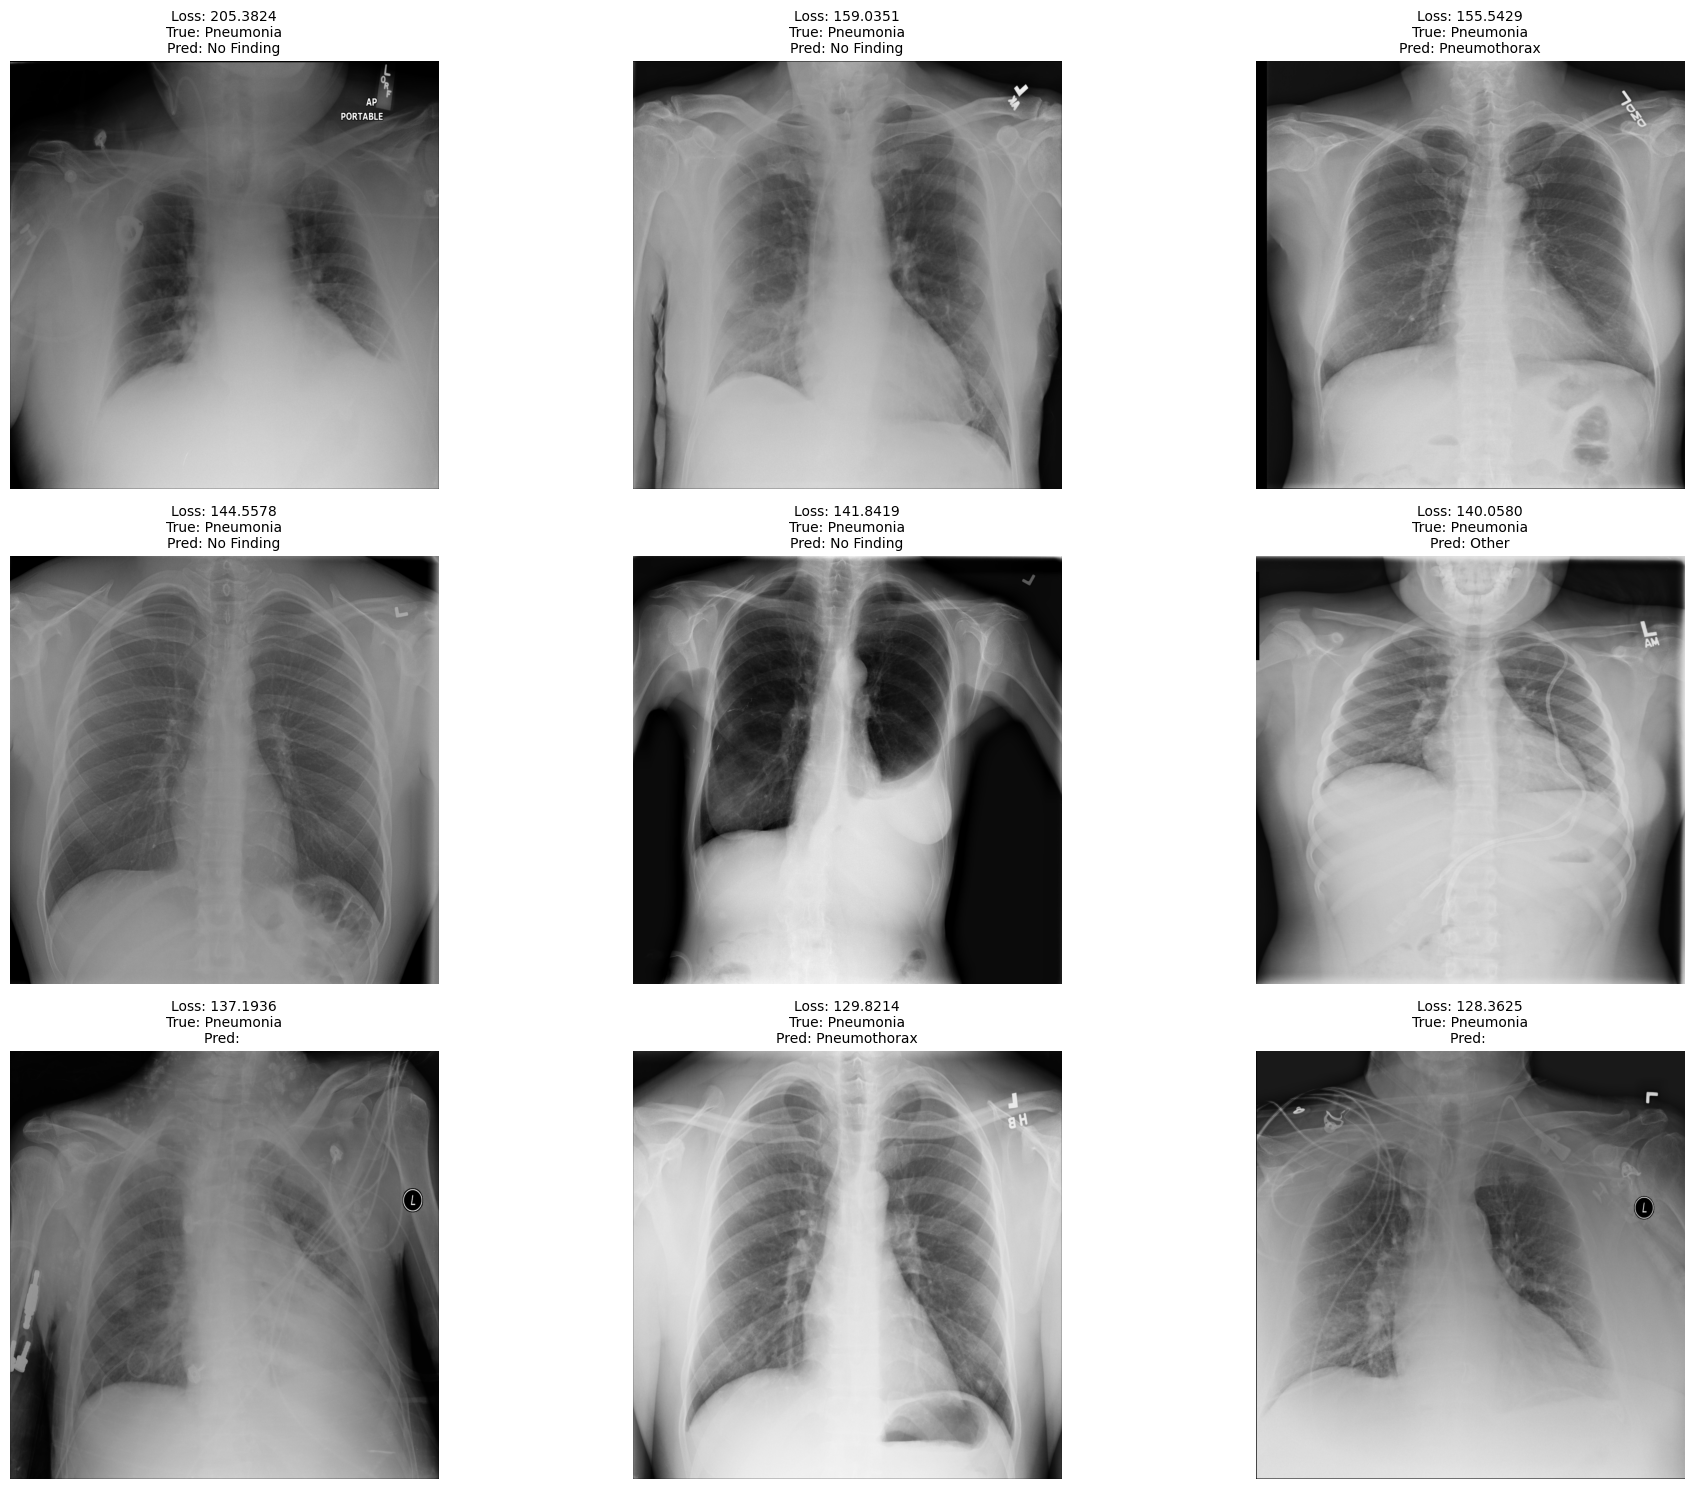

In [44]:
# Compute losses for the validation set
val_losses, val_preds, val_targets, val_img_files = compute_losses(model, val_loader, criterion, device)

# Plot top losses
plot_top_losses(val_losses, val_preds, val_targets, path_text, val_img_files, label_to_idx)

# Sample Predictions

In [45]:
def predict(model, image_path, device, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.sigmoid(outputs)
    
    return probabilities.cpu().numpy().squeeze()

In [46]:
def interpret_predictions(probabilities, label_to_idx, threshold=0.5):
    idx_to_label = {v: k for k, v in label_to_idx.items()}
    interpreted_results = []
    
    for idx, prob in enumerate(probabilities):
        label = idx_to_label[idx]
        interpreted_results.append({
            'label': label,
            'probability': prob,
            'predicted': prob > threshold
        })
    
    # Sort by probability in descending order
    interpreted_results.sort(key=lambda x: x['probability'], reverse=True)
    
    return interpreted_results

In [50]:
# Example prediction
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Redefine (already defined just for testing for quick tweaking)
model = model.to(device)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_path = './unseen_data/PNEUMONIA/person1946_bacteria_4874.jpeg'
probabilities = predict(model, image_path, device, transform)
results = interpret_predictions(probabilities, label_to_idx)

# Print the results
print("Predictions:")
for result in results:
    status = "Positive" if result['predicted'] else "Negative"
    print(f"{result['label']}: {result['probability']:.4f} ({status})")

Predictions:
No Finding: 0.6313 (Positive)
Other: 0.3325 (Negative)
Pneumonia: 0.1739 (Negative)
Pneumothorax: 0.1499 (Negative)


In [48]:
# Get the top N predictions
top_n = 5
print(f"\nTop {top_n} predictions:")
for result in results[:top_n]:
    status = "Positive" if result['predicted'] else "Negative"
    print(f"{result['label']}: {result['probability']:.4f} ({status})")


Top 5 predictions:
Pneumothorax: 0.9104 (Positive)
Other: 0.2831 (Negative)
No Finding: 0.2623 (Negative)
Pneumonia: 0.0048 (Negative)


# Save Model

In [49]:
# Save the model
torch.save(model.state_dict(), 'resnet50_multilabel_model.pth')

# Run Model on Test Set